In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm

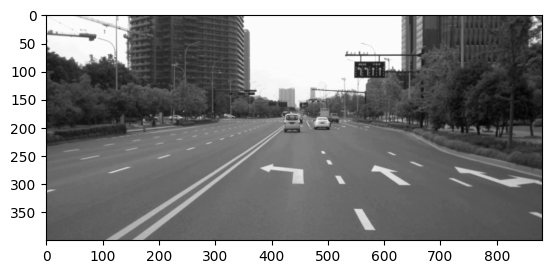

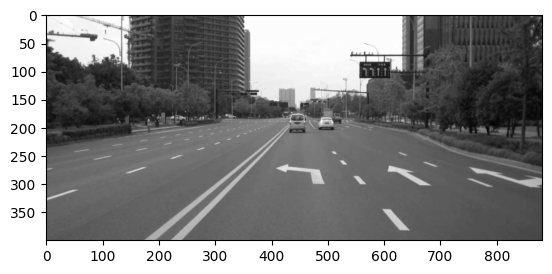

In [6]:
left = cv2.imread('data/left.jpg')
right = cv2.imread('data/right.jpg')

left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

plt.imshow(right_gray, cmap='gray')
plt.show()

plt.imshow(left_gray, cmap='gray')
plt.show()

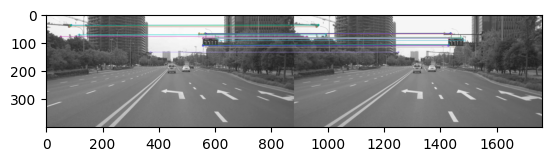

(30, 2) (30, 2) (30,)
(3, 3) (30,)


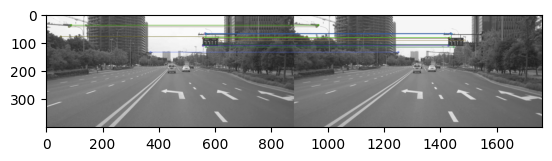

(<matplotlib.image.AxesImage at 0x14573d4b0>, None)

In [27]:
orb = cv2.ORB_create( nfeatures=100, scaleFactor=1.2, nlevels=8, edgeThreshold=15, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)
kp1, des1 = orb.detectAndCompute(left_gray, None)
kp2, des2 = orb.detectAndCompute(right_gray, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)[:30]

img3 = cv2.drawMatches(left_gray, kp1, right_gray, kp2, matches, None, flags=2)
plt.imshow(img3), plt.show()

best_kp1 = []
best_kp2 = []
best_matches = []

for match in matches:
	best_kp1.append(kp1[match.queryIdx].pt)
	best_kp2.append(kp2[match.trainIdx].pt)
	best_matches.append(match)

best_kp1 = np.array(best_kp1)
best_kp2 = np.array(best_kp2)
best_matches = np.array(best_matches)

print(best_kp1.shape, best_kp2.shape, best_matches.shape)

F, inlier_mask = cv2.findFundamentalMat(best_kp1, best_kp2, cv2.FM_7POINT)
# print(inlier_mask)
inlier_mask = inlier_mask.flatten()

print(F.shape, inlier_mask.shape)
# print(inlier_mask)
#points within epipolar lines
inlier_kp1 = best_kp1[inlier_mask == 1]
inlier_kp2 = best_kp2[inlier_mask == 1]

inlier_matches = best_matches[inlier_mask==1]


img3 = cv2.drawMatches(left_gray, kp1, right_gray, kp2, inlier_matches, None, flags=2)
plt.imshow(img3),plt.show()

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
hello [[1.00000000e+00 0.00000000e+00 3.41060513e-12]
 [0.00000000e+00 1.00000000e+00 7.49037464e-12]]
[[1.00000000e+00 0.00000000e+00 3.41060513e-12]
 [0.00000000e+00 1.00000000e+00 7.49037464e-12]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


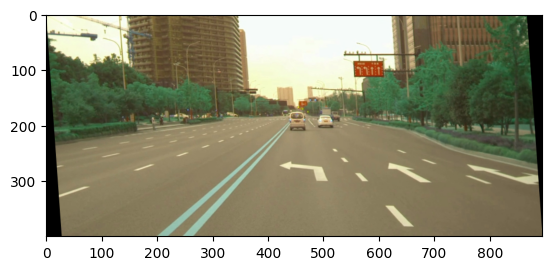

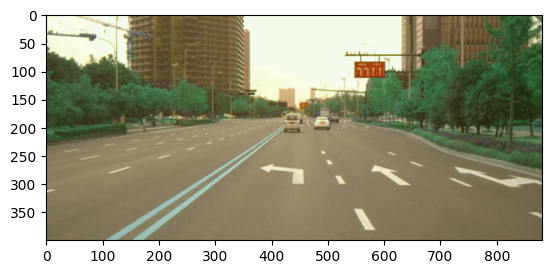

True

In [33]:
thresh = 0

_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(inlier_kp1), np.float32(inlier_kp2), F, left_gray.shape[::-1])

I1_rect = np.float32([[[0, 0], [left_gray.shape[1], 0], [left_gray.shape[1], left_gray.shape[0]], [0, left_gray.shape[0]]]])
warped_I1_rect = cv2.perspectiveTransform(I1_rect, H1)

I2_rect = np.float32([[[0, 0], [right_gray.shape[1], 0], [right_gray.shape[1], right_gray.shape[0]], [0, right_gray.shape[0]]]])
warped_I2_rect = cv2.perspectiveTransform(I2_rect, H2)

min_x_I1= min(warped_I1_rect[0][0][0], warped_I1_rect[0][1][0], warped_I1_rect[0][2][0], warped_I1_rect[0][3][0])
min_x_I2 =min(warped_I2_rect[0][0][0], warped_I2_rect[0][1][0], warped_I2_rect[0][2][0], warped_I2_rect[0][3][0])

min_y_I1 = min(warped_I1_rect[0][0][1], warped_I1_rect[0][1][1], warped_I1_rect[0][2][1], warped_I1_rect[0][3][1])
min_y_I2 = min(warped_I2_rect[0][0][1], warped_I2_rect[0][1][1], warped_I2_rect[0][2][1], warped_I2_rect[0][3][1])

max_x_I1 = max(warped_I1_rect[0][0][0], warped_I1_rect[0][1][0], warped_I1_rect[0][2][0], warped_I1_rect[0][3][0])
max_x_I2 = max(warped_I2_rect[0][0][0], warped_I2_rect[0][1][0], warped_I2_rect[0][2][0], warped_I2_rect[0][3][0])

max_y_I1 = max(warped_I1_rect[0][0][1], warped_I1_rect[0][1][1], warped_I1_rect[0][2][1], warped_I1_rect[0][3][1])
max_y_I2 = max(warped_I2_rect[0][0][1], warped_I2_rect[0][1][1], warped_I2_rect[0][2][1], warped_I2_rect[0][3][1])
 
translation_xy_I1 = np.array([max(0, -min_x_I1), max(0, -min_y_I1)])
translation_xy_I2 = np.array([max(0, -min_x_I2), max(0, -min_y_I2)])

W_I1 = (max_x_I1 + translation_xy_I1[0])
H_I1 = (max_y_I1 + translation_xy_I1[1])

W_I2 = (max_x_I2 + translation_xy_I2[0])
H_I2 = (max_y_I2 + translation_xy_I2[1])

transform_T = np.eye(3)
print(transform_T)
transform_T[0,2] = translation_xy_I1[0]
transform_T[1,2] = translation_xy_I1[1]
transform_T = transform_T[:2, :]

H1 = np.concatenate((transform_T, [[0, 0, 1]]), axis=0) @ H1

transform_T = np.eye(3)
transform_T[0,2] = translation_xy_I2[0]
transform_T[1,2] = translation_xy_I2[1]
transform_T = transform_T[:2, :]


H2 = np.concatenate((transform_T, [[0, 0, 1]]), axis=0) @ H2

stereo_L = cv2.warpPerspective(left, H1, (int(W_I1),int(H_I1)))
stereo_R = cv2.warpPerspective(right, H2, (int(W_I2),int(H_I2)))

plt.imshow(stereo_L)
plt.show()
plt.imshow(stereo_R)
plt.show()

# save the images
cv2.imwrite('data/stereo_L.jpg', stereo_L)
cv2.imwrite('data/stereo_R.jpg', stereo_R)

In [3]:
import os
import cv2

list_files = os.listdir('data/left')
list_files.sort()

# create folder inside data
if not os.path.exists('data/chinese_car'):
    os.makedirs('data/chinese_car')

for i , file_name in enumerate(list_files):
    left_img = cv2.imread('data/left/'+file_name)
    right_img = cv2.imread('data/right/'+file_name)
    os.makedirs('data/chinese_car/'+str(i+1))
    cv2.imwrite('data/chinese_car/'+str(i+1)+'/left.jpg', left_img)
    cv2.imwrite('data/chinese_car/'+str(i+1)+'/right.jpg', right_img)